In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import subprocess
import scipy as sc
from itertools import product

mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 10,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "figure.figsize": (4, 3.5),
    "text.latex.preamble": "\n".join([
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[T1]{fontenc}",
        r"\usepackage[detect-all,locale=FR]{siunitx}",
    ]),
    'lines.markersize': 10,
    'lines.color': 'grey',
    'scatter.marker': '+',
    'errorbar.capsize': 3,
    'savefig.bbox': 'tight',
})

In [2]:
path = '../'
executable = 'bin/ex2'
export_path = path + 'rapport/figures/'
data_path = 'data/'
config_path = 'bin/'
config_name = 'retraction'
config_ext = '.conf'

In [3]:
def stringify_dict(d: dict, sep=',') -> str:
    return sep.join(map(lambda a: str(a[0]) + "=" + str(a[1]), tuple(d.items())))

In [4]:
def run(config_file: str, output_file: str, params: dict = {}) -> None:
    # print(f"Running with config file {config_file}")
    options = stringify_dict(params, sep=' ')
    cmd = f"{path}{executable} {path}{config_file} output='{path}{output_file}' {options}"
    print(f"Running command `{cmd}`")
    subprocess.run(cmd, shell=True, stdout=subprocess.DEVNULL)
    # print("Done")

In [5]:
# nsteps = np.array([*range(500, 2001, 100)])
nsteps = np.linspace(1000, 10000, 100)
nsimul = len(nsteps)  # Number of simulations to perform

conf = {}
with open(path + config_path + config_name + config_ext, 'r') as f:
    lines = f.read().split('\n')

for line in lines:
    if not line:
        continue
    name, _, val, *_ = line.split(' ')
    name = name.strip()
    val = val.strip()
    try:
        conf[name] = float(val)
    except ValueError:
        conf[name] = val

# Vérfier bon tFin
assert 0.96 * conf['L'] / abs(conf['alpha']) == conf['tFin']
dt = conf['tFin'] / nsteps

In [6]:
%%bash
cd .. && make clean && make

clang++ -o bin/ex2 src/Ex2_2024_student.cpp -std=c++17 -Wall -Wextra -O2 


In [7]:
params_variations = {
    'nsteps': nsteps,
}
all_params = tuple(
    {a: b for a, b in zip(params_variations.keys(), c)} for c in product(*params_variations.values())
)

# Run simulations
outputs = []  # List to store output file names
for params in all_params:
    output_file = f"{data_path}{config_name},{stringify_dict(params)}.out"
    outputs.append(output_file)
    run(f'{config_path}{config_name}{config_ext}', output_file, params)

Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1000.0.out' nsteps=1000.0`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1090.909090909091.out' nsteps=1090.909090909091`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1181.8181818181818.out' nsteps=1181.8181818181818`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1272.7272727272727.out' nsteps=1272.7272727272727`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1363.6363636363635.out' nsteps=1363.6363636363635`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1454.5454545454545.out' nsteps=1454.5454545454545`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retraction,nsteps=1545.4545454545455.out' nsteps=1545.4545454545455`
Running command `../bin/ex2 ../bin/retraction.conf output='../data/retract

In [8]:
# Load stuff in memory
all_data = {}

for file, params in zip(outputs, all_params):
    data = np.loadtxt(path + file)
    all_data[file] = (params, np.copy(data))
    

# Plots!

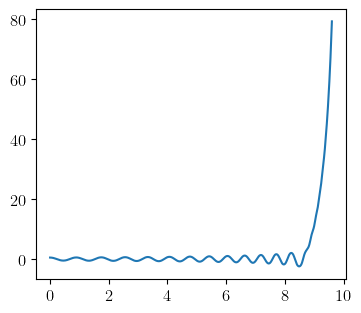

In [9]:
%matplotlib inline
for (params, data) in all_data.values():
    if params['nsteps'] > 1000:
        continue
    t, theta, thetadot, l = data[:,0], data[:,1], data[:,2], data[:,5]
    # x = l * np.sin(theta)
    # y = -l * np.cos(theta)
    # plt.plot(x,y)
    plt.plot(t, theta)

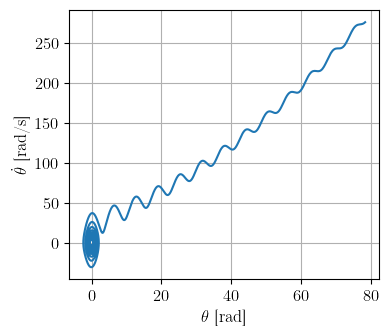

In [16]:
%matplotlib inline
plt.close()
tfin = conf['tFin']
cache = [99]
colors = mpl.colormaps['rainbow'](np.linspace(0.2, 1, len(all_data)))
for i,  (params, data) in enumerate(all_data.values()):
    if i in cache:
        t, theta, thetadot = data[:,0], data[:,1], data[:,2]
        plt.plot(theta, thetadot, label=f"$\\Delta t={(tfin/params['nsteps']):.5f}$")

# plt.axis('equal')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'phase_retraction.pdf')

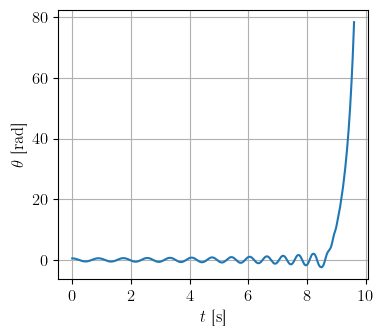

In [17]:
%matplotlib inline
# plt.close()
tfin = conf['tFin']
cache = [99]
colors = mpl.colormaps['rainbow'](np.linspace(0.2, 1, len(all_data)))
for i,  (params, data) in enumerate(all_data.values()):
    if i in cache:
        t, theta, thetadot = data[:,0], data[:,1], data[:,2]
        plt.plot(t, theta, label=f"$\\Delta t={(tfin/params['nsteps']):.5f}$")

# plt.axis('equal')
plt.xlabel(r'$t$ [s]')
plt.ylabel(r'$\theta$ [rad]')
# plt.legend()
plt.grid()
plt.savefig(export_path + 'traj_retraction.pdf')

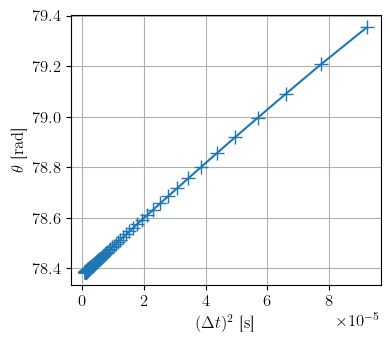

In [12]:
def calc(dataset: dict):
    stuffies = []
    for i, (params, data) in enumerate(dataset.values()):
        tf, thetaf = data[:, 0], data[-1, 1]
        stuffies.append(thetaf)
    return stuffies

norder = 2
stuff = calc(all_data)
plt.plot(dt**norder, stuff, '+-', label=r'$\theta$')
plt.xlabel(r'$(\Delta t)^2$ [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid()
plt.savefig(export_path + 'converg_retraction.pdf')